# Tensorflow project (CNN Classifier)

https://www.tensorflow.org/tutorials/images/cnn

http://cs231n.github.io/

Trained model should be able to classify input images to one of 43 classes (for testing purposes 10 classes might be enough).

## [Data](https://sid.erda.dk/public/)

- [Train dataset](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip)
- [Test dataset](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip)
- [Test data csv with assigned classification](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip)

## Image format

- The images contain one traffic sign each
- Images contain a border of 10 % around the actual traffic sign (at least 5 pixels) to allow for edge-based approaches
- Images are stored in PPM format (Portable Pixmap, P6)
- Image sizes vary between 15x15 to 250x250 pixels
- Images are not necessarily squared
- The actual traffic sign is not necessarily centered within the image.This is true for images that were close to the image border in the full camera image
- The bounding box of the traffic sign is part of the annotatinos (see below)

## Annotation format

Annotations are provided in CSV files. Fields are separated by “;” (semicolon). Annotations contain the following information:

- Filename: Filename of corresponding image
- Width: Width of the image
- Height: Height of the image
- ROI.x1: X-coordinate of top-left corner of traffic sign bounding box
- ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box
- ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box
- ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box



In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

2024-04-04 09:53:47.611697: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 09:53:47.614216: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 09:53:47.649613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 09:53:48.323871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

## Loading & prepare training images

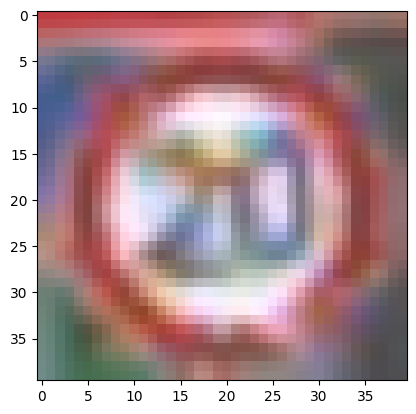

In [2]:
data_range = range(0, 10)
image_final_size = (40, 40)
training_data_path = "./GTSRB/Final_Training/Images/"

csv_data = []
X_train = []
y_train = []

for i in data_range:
    number = "0000" + str(i)
    data_path = os.path.join(training_data_path, number)
    raw_csv=pd.read_csv(os.path.join(data_path, "GT-"+number+".csv"), delimiter=";")
    csv_data.append(raw_csv)

    raw_csv["Filename"].apply(lambda x: X_train.append(Image.open(os.path.join(data_path, x))))
    raw_csv["ClassId"].apply(lambda y: y_train.append(y))

images_df = pd.concat(csv_data, ignore_index=True)

for i in range(len(images_df)):
    image_data = images_df.loc[i]
    x1, y1, x2, y2 = image_data["Roi.X1"], image_data["Roi.Y1"], image_data["Roi.X2"], image_data["Roi.Y2"]
    X_train[i] = np.asarray(X_train[i].crop((x1, y1, x2, y2)).resize(image_final_size))

plt.imshow(X_train[0])